**FAIRE PRESENTATION DU NOTEBOOK + SOMMAIRE**

In [1]:
%reload_ext autoreload
%autoreload 2

In [341]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Fichier perso
import exploration as ex

# plt.style.use('fivethirtyeight')
# plt.rcParams['figure.figsize'] = (12, 8)
# plt.rcParams['figure.dpi'] = 100

pd.set_option('plotting.backend', 'plotly')
pd.set_option("display.min_rows", 10)
pd.set_option("display.max_columns", 50)
pd.set_option('display.max_colwidth', None)

In [3]:
prefix = './csv_files/'

customers = pd.read_csv(prefix + 'olist_customers_dataset.csv')
geolocation = pd.read_csv(prefix + 'olist_geolocation_dataset.csv', dtype={'geolocation_zip_code_prefix': str})
items = pd.read_csv(prefix + 'olist_order_items_dataset.csv')
payments = pd.read_csv(prefix + 'olist_order_payments_dataset.csv')
reviews = pd.read_csv(prefix + 'olist_order_reviews_dataset.csv')
orders = pd.read_csv(prefix + 'olist_orders_dataset.csv').astype({'order_purchase_timestamp':'datetime64','order_approved_at':'datetime64','order_delivered_carrier_date':'datetime64','order_delivered_customer_date':'datetime64','order_estimated_delivery_date':'datetime64'})
products = pd.read_csv(prefix + 'olist_products_dataset.csv')
sellers = pd.read_csv(prefix + 'olist_sellers_dataset.csv') # Non-pertinent pour l'étude

dict_csv = {'customers':customers, 'geolocation':geolocation, 'items':items, 'payments':payments,
            'reviews':reviews, 'orders':orders, 'products':products, 'sellers':sellers}

Je fusionne l'ensemble des datasets pour pouvoir sélectionner plus facilement les colonnes nécessaires.

<div>
<img src="https://i.imgur.com/HRhd2Y0.png" width="1000"/>
</div>

Le schéma ci-dessus me donne les liens entre chacun des datasets. Je vais suivre ces liens pour les fusionner. <br>

In [6]:
data =  pd.merge(products,
            pd.merge(items,
                    pd.merge(customers,
                            pd.merge(payments,
                                    pd.merge(orders,
                                             reviews, 
                                             how='inner', on='order_id'
                                            ),
                                    how='inner', on='order_id'
                                    ),
                             how='inner', on='customer_id'
                            ),
                     how='inner', on='order_id'
                    ),
        how='inner', on='product_id'
        )

Je créé les variables total_price et total_freight_price correspondant aux prix et fdp totaux pour une commande.

In [8]:
data['order_total_price'] = data.order_id.apply(func=lambda id: data[data.order_id == str(id)].price.sum())

data['order_total_freight'] = data.order_id.apply(func=lambda id: data[data.order_id == str(id)].freight_value.sum())

In [131]:
data.groupby('order_id').sum()['price']

order_id
00010242fe8c5a6d1ba2dd792cb16214     58.90
00018f77f2f0320c557190d7a144bdd3    239.90
000229ec398224ef6ca0657da4fc703e    199.00
00024acbcdf0a6daa1e931b038114c75     12.99
00042b26cf59d7ce69dfabb4e55b4fd9    199.90
                                     ...  
fffc94f6ce00a00581880bf54a75a037    299.99
fffcd46ef2263f404302a634eb57f7eb    350.00
fffce4705a9662cd70adb13d4a31832d     99.90
fffe18544ffabc95dfada21779c9644f     55.99
fffe41c64501cc87c801fd61db3f6244     43.00
Name: price, Length: 98665, dtype: float64

# RFM

Je calcule ici le score RFM pour chaque client. <br>
**Récence**: Quand était le dernier achat ? <br>
**Fréquence**: Cb de fois le client a-t-il fait un achat durant cette période donnée ? <br>
**Montant**: Moyenne des dépenses du client <br>

In [113]:
rfm_df = data[['customer_unique_id', 'order_id', 'order_approved_at', 'order_total_price', 'order_total_freight']]

Je créé les variables total_price et total_freight_price correspondant aux prix et fdp totaux pour une commande.

## Preprocessing

### Restriction à la période d'étude

Comme présenté dans l'EDA, une période d'étude plus pertinente serait du **1er Janvier 2017 au 26 Aout 2018**, en dehors de cette période la quantité d'achat est trop instable pour être considéré comme valide.

In [114]:
from datetime import datetime

debut = datetime(2017,1,1,0,0,0)
fin = datetime(2018,8,26,23,59,59)

rfm_df = rfm_df[(rfm_df.order_approved_at >= debut) & (rfm_df.order_approved_at <= fin)]

In [115]:
print(f'Période d\'étude: {rfm_df.order_approved_at.min().ctime()} à {rfm_df.order_approved_at.max().ctime()}')

Période d'étude: Thu Jan  5 12:10:17 2017 à Sun Aug 26 23:45:08 2018


### Suppression des NaNs

In [144]:
rfm_df.isnull().sum()

customer_unique_id     0
order_id               0
order_approved_at      0
order_total_price      0
order_total_freight    0
dtype: int64

Pas de NaNs sur nos variables.

### Doublons

Le merging a créé des doublons, je les retire.

In [128]:
rfm_df.order_id.duplicated().sum()

19548

In [139]:
rfm_df.drop_duplicates(inplace=True)

## Modélisation

Pour la date du dernier achat (**Récence**), on considère la date de la variable *fin* comme le jour de comparaison

In [212]:
customer_recence = fin - rfm_df.groupby('customer_unique_id').min()['order_approved_at']
customer_recence = customer_recence.apply(func=lambda x: x.days) # Je ne conserve que les jours

Pour la **fréquence**, on regarde combien d'achats ont fait chaque client sur notre période d'étude

In [146]:
rfm_df_vc = rfm_df.customer_unique_id.value_counts()

In [176]:
rfm_df['customer_nb_total_commands'] = rfm_df.customer_unique_id.apply(func=lambda id: rfm_df_vc.loc[id])

In [194]:
customer_nb_total_commands = rfm_df.groupby('customer_unique_id').max()['customer_nb_total_commands'].copy()

In [193]:
tmp.sort_values(inplace=True)

Le **montant** est la somme des moyennes de commande + livraison

In [149]:
customer_mean_total_expenses = rfm_df.groupby('customer_unique_id').mean()['order_total_price'] + rfm_df.groupby('customer_unique_id').mean()['order_total_freight']

Je rassemble ici mes 3 variables en 1 dataset final.

In [173]:
set(customer_recence.index) - set(customer_mean_total_expenses.index)

set()

In [181]:
set(customer_recence.index) - set(customer_nb_total_commands.index)

set()

In [214]:
customer_recence.sort_index(inplace=True)
customer_mean_total_expenses.sort_index(inplace=True)
customer_nb_total_commands.sort_index(inplace=True)


rfm_final = pd.DataFrame(data={'recence': customer_recence, 'frequence': customer_nb_total_commands, 'montant':customer_mean_total_expenses}, index=customer_recence.index)

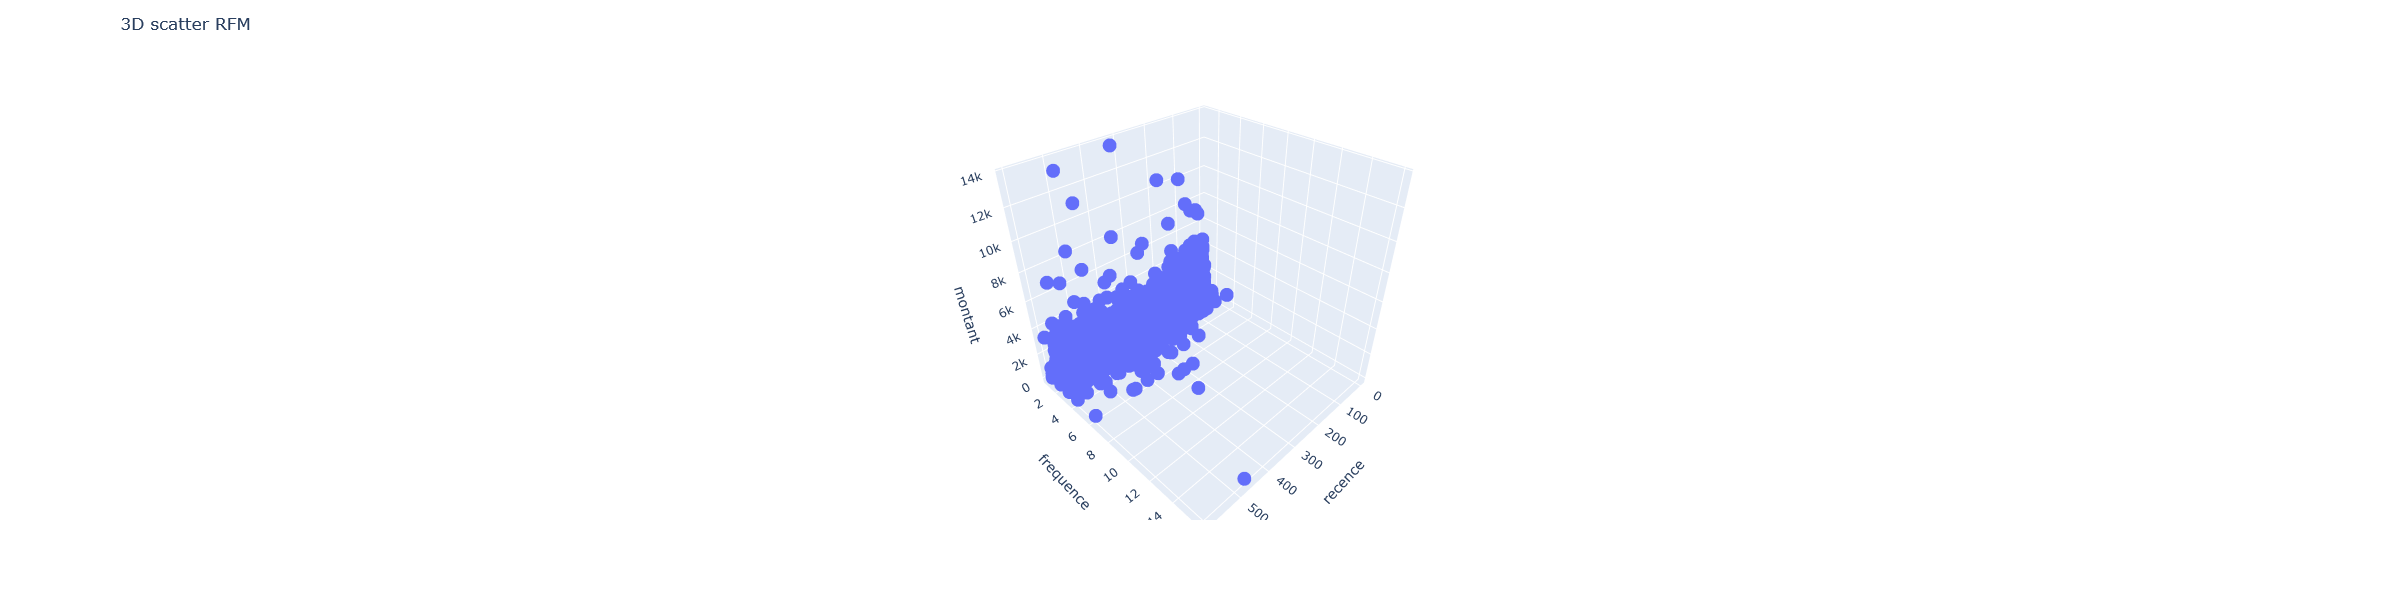

In [221]:
fig = px.scatter_3d(rfm_final, x='recence', y='frequence', z='montant')
fig.update_layout(dict1={'title':'3D scatter RFM', 'width':600, 'height':600})
fig.show()

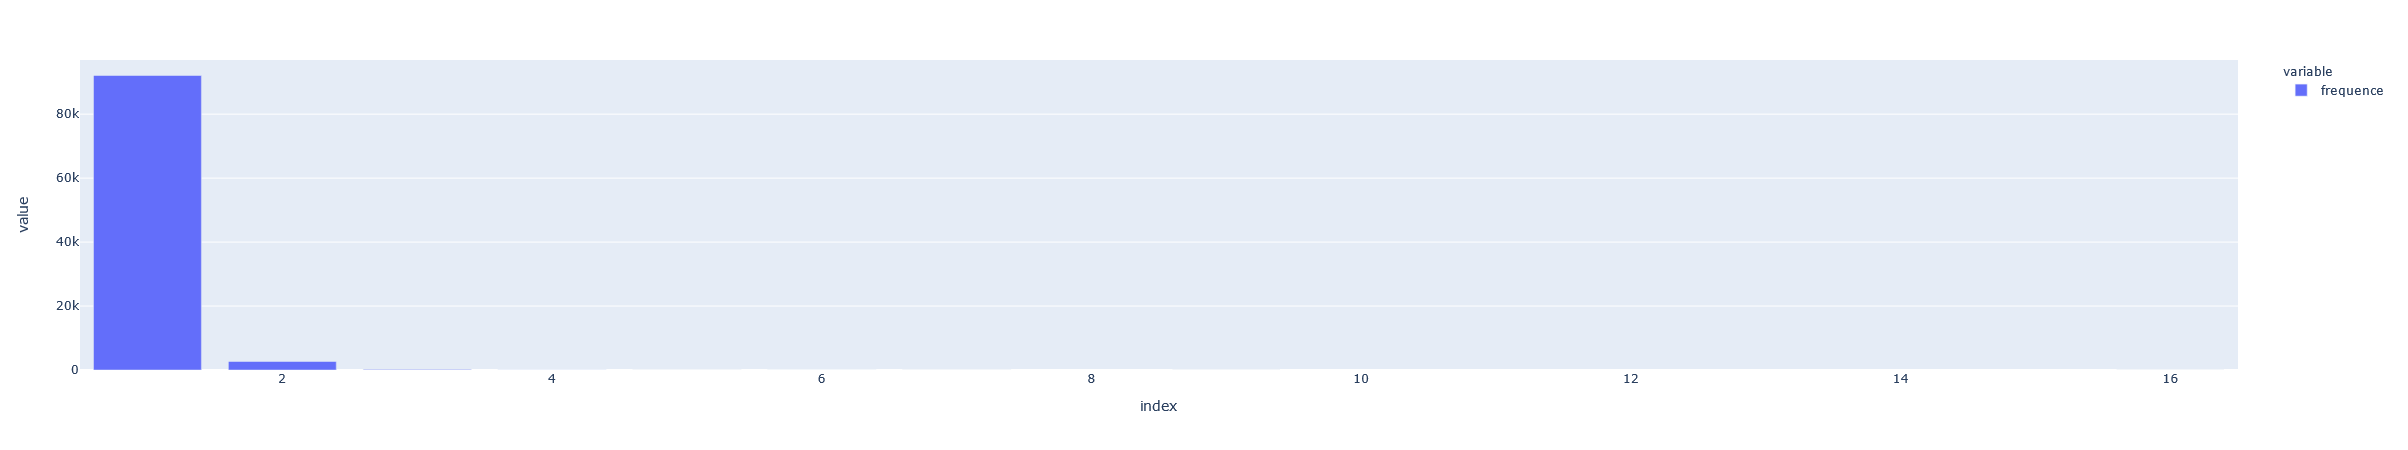

In [220]:
px.bar(rfm_final.frequence.value_counts())

<font color='red'> <b>Observations</b></font> <br>

- Les variations de la dimension fréquence sont très faibles (la très grande majorité des clients n'ayant commandé qu'une unique fois)

Afin de déterminer le score de chacun des clients, il faut maintenant que je définisse les règles de scoring. <br>
Pour cela, je trie par puis découpe en 4 chacune de mes variables. <br> 
Pour chaque RFM de chaque client, le quartile auquel appartient le client défini un score (voir tableau ci-dessous) <br>
<br>
Exemples: 
- Le client achète avec les montants les plus élevés --> M=1
- Le client a acheté il y a peu --> R=1

<div>
<img src="https://lh5.googleusercontent.com/tQJ9PVI1W8ojjDRygl7GbvbcXP_PsQHs4VG6epuCpezv-cfc-a_bPNaNSTjVLXGJA8rNhbGIkuFKksg7U5Wh4AbuVREYVEeBLX2ljVISl7Kg__6GSIE5wGY8bVDjFD__R9LwqgIv" width="1000"/>
</div>

In [258]:
def rfm_quartile(rfm: pd.DataFrame, col: str):

    mini = rfm[col].min(); q1 = np.quantile(rfm[col], 0.25)
    q2 = np.quantile(rfm[col], 0.5); q3 = np.quantile(rfm[col], 0.75)

    return {'mini':mini, 'q1':q1, 'q2':q2, 'q3':q3}

In [259]:
q_recence = rfm_quartile(rfm_final, col='recence')
q_frequence = rfm_quartile(rfm_final, col='frequence')
q_montant = rfm_quartile(rfm_final, col='montant')

In [261]:
q_montant

{'mini': 10.07, 'q1': 63.4, 'q2': 108.17, 'q3': 183.01}

In [263]:
def score_recence(value):
    if value <= q_recence['q1']:
        return 1
    elif value > q_recence['q1'] and value <= q_recence['q2']:
        return 2
    elif value > q_recence['q2'] and value <= q_recence['q3']:
        return 3
    else:
        return 4

def score_frequence(value):
    if value <= q_frequence['q1']:
        return 4
    elif value > q_frequence['q1'] and value <= q_frequence['q2']:
        return 3
    elif value > q_frequence['q2'] and value <= q_frequence['q3']:
        return 2
    else:
        return 1
    
def score_montant(value):
    if value <= q_montant['q1']:
        return 4
    elif value > q_montant['q1'] and value <= q_montant['q2']:
        return 3
    elif value > q_montant['q2'] and value <= q_montant['q3']:
        return 2
    else:
        return 1

In [265]:
r_score = rfm_final.recence.apply(func=score_recence)
f_score = rfm_final.frequence.apply(func=score_frequence)
m_score = rfm_final.montant.apply(func=score_montant)

In [269]:
rfm_final['score'] = r_score.astype('str') + '-' + f_score.astype('str') + '-' + m_score.astype('str')

rfm_final

recence  frequence  montant  score
customer_unique_id                                                  
0000366f3b9a7992bf8c76cfdf3221e2      108          1   141.90  1-4-2
0000b849f77a49e4a4ce2b2a4ca5be3f      111          1    27.19  1-4-4
0000f46a3911fa3c0805444483337064      534          1    86.22  4-4-3
0000f6ccb0745a6a4b88665a16c9f078      318          1    43.62  3-4-4
0004aac84e0df4da2b147fca70cf8255      285          1   196.89  3-4-1
...                                   ...        ...      ...    ...
fffcf5a5ff07b0908bd4e2dbc735a684      444          1  2067.42  4-4-1
fffea47cd6d3cc0a88bd621562a9d061      259          1    84.58  3-4-3
ffff371b4d645b6ecea244b27531430a      565          1   112.46  4-4-2
ffff5962728ec6157033ef9805bacc48      116          1   133.69  2-4-2
ffffd2657e2aad2907e67c3e9daecbeb      480          1    71.56  4-4-3

[94979 rows x 4 columns]

En fonction des scores, je peux attribuer une catégorie aux clients.

In [361]:
customer_segment = pd.DataFrame()
segment = ["Best Customers", "Loyal Customers", "Big Spenders", "Almost Lost",
           "Lost Customers", "Lost Cheap Customers", "Others"
          ]
rfm = ["1-1-1", "X-1-X", "X-X-1", "3-1-1", "4-1-1", "4-4-4", "Others"]
description = ["A acheté le plus récemment, le plus souvent et dépensé le plus.",
               "A acheté le plus récemment",
               "Dépense le plus",
               "N'a pas acheté depuis un temps, mais a acheté fréquemment et dépensé le plus.",
               "N'a pas acheté depuis très longtemps, mais a acheté fréquemment et dépensé le plus.",
               "Dernier achat il y a longtemps, a acheté peu et dépensé peu.",
               ""
              ]
action = ["Pas d'incitation aux prix, Nouveaux produits et programmes de fidélité",
             "Vendre des produits de plus grande valeur. Demandez des commentaires. Engagez-les.",
             "Commercialisez vos produits les plus chers.",
             "Offrez d'autres produits pertinents et des rabais spéciaux.",
             "Incitations à des prix agressifs",
             "Ne passez pas trop de temps à essayer de vous ré-acquérir.",
             "Ajuster les intervales pour le réduire si important"
            ]
customer_segment["rfm"] = rfm
customer_segment["segments clients"] = segment

In [362]:
nb_clients = []

X1X = ["1-1-2", "1-1-3", "1-1-4", "2-1-1", "2-1-2", "2-1-3", "2-1-4"]
XX1 = ["1-4-1",  "2-4-1"] # "1-2-1", "1-3-1", "2-2-1", "2-3-1",non présents

nb_clients.append(rfm_final.score.value_counts().loc['1-1-1'])
nb_clients.append(rfm_final.score.value_counts().loc[X1X].sum())
nb_clients.append(rfm_final.score.value_counts().loc[XX1].sum())
nb_clients.append(rfm_final.score.value_counts().loc['3-1-1'])
nb_clients.append(rfm_final.score.value_counts().loc['4-1-1'])
nb_clients.append(rfm_final.score.value_counts().loc['4-4-4'])
nb_clients.append((rfm_final.score.value_counts()).sum() - sum(nb_clients)) # Others

customer_segment['nb_clients'] = nb_clients/sum(nb_clients) *100
customer_segment['description'] = description
customer_segment['action'] = action

customer_segment

rfm      segments clients  nb_clients  \
0   1-1-1        Best Customers    0.081071   
1   X-1-X       Loyal Customers    0.911780   
2   X-X-1          Big Spenders   12.265869   
3   3-1-1           Almost Lost    0.208467   
4   4-1-1        Lost Customers    0.322176   
5   4-4-4  Lost Cheap Customers    6.065551   
6  Others                Others   80.145085   

                                                                           description  \
0                      A acheté le plus récemment, le plus souvent et dépensé le plus.   
1                                                           A acheté le plus récemment   
2                                                                      Dépense le plus   
3        N'a pas acheté depuis un temps, mais a acheté fréquemment et dépensé le plus.   
4  N'a pas acheté depuis très longtemps, mais a acheté fréquemment et dépensé le plus.   
5                         Dernier achat il y a longtemps, a acheté peu et dépensé peu.   
6                                                                                        

                                                                               action  
0              Pas d'incitation aux prix, Nouveaux produits et programmes de fidélité  
1  Vendre des produits de plus grande valeur. Demandez des commentaires. Engagez-les.  
2                                         Commercialisez vos produits les plus chers.  
3                         Offrez d'autres produits pertinents et des rabais spéciaux.  
4                                                    Incitations à des prix agressifs  
5                          Ne passez pas trop de temps à essayer de vous ré-acquérir.  
6                                 Ajuster les intervales pour le réduire si important

Je note que 80 % des clients sont dans la catégorie "Others", je cherche à savoir où se trouve la plus grande partie du CA.

In [363]:
CA = []
CA_total = rfm_final.groupby('score').sum()['montant'].sum()

CA.append(rfm_final.groupby('score').sum()['montant'].loc['1-1-1'])
CA.append(rfm_final.groupby('score').sum()['montant'].loc[X1X].sum())
CA.append(rfm_final.groupby('score').sum()['montant'].loc[XX1].sum())
CA.append(rfm_final.groupby('score').sum()['montant'].loc['3-1-1'])
CA.append(rfm_final.groupby('score').sum()['montant'].loc['4-1-1'])
CA.append(rfm_final.groupby('score').sum()['montant'].loc['4-4-4'])
CA.append(CA_total - sum(CA))

customer_segment.insert(3,'CA', CA/CA_total)

In [364]:
customer_segment

rfm      segments clients  nb_clients        CA  \
0   1-1-1        Best Customers    0.081071  0.001837   
1   X-1-X       Loyal Customers    0.911780  0.007944   
2   X-X-1          Big Spenders   12.265869  0.293361   
3   3-1-1           Almost Lost    0.208467  0.004497   
4   4-1-1        Lost Customers    0.322176  0.006568   
5   4-4-4  Lost Cheap Customers    6.065551  0.015760   
6  Others                Others   80.145085  0.670034   

                                                                           description  \
0                      A acheté le plus récemment, le plus souvent et dépensé le plus.   
1                                                           A acheté le plus récemment   
2                                                                      Dépense le plus   
3        N'a pas acheté depuis un temps, mais a acheté fréquemment et dépensé le plus.   
4  N'a pas acheté depuis très longtemps, mais a acheté fréquemment et dépensé le plus.   
5                         Dernier achat il y a longtemps, a acheté peu et dépensé peu.   
6                                                                                        

                                                                               action  
0              Pas d'incitation aux prix, Nouveaux produits et programmes de fidélité  
1  Vendre des produits de plus grande valeur. Demandez des commentaires. Engagez-les.  
2                                         Commercialisez vos produits les plus chers.  
3                         Offrez d'autres produits pertinents et des rabais spéciaux.  
4                                                    Incitations à des prix agressifs  
5                          Ne passez pas trop de temps à essayer de vous ré-acquérir.  
6                                 Ajuster les intervales pour le réduire si important

# Preprocessing

- Je normalise l'ensemble de mes variables textes
- Suppression des outliers (not delivered, restreindre la période d'étude)


    An order might have multiple items.
    Each item might be fulfilled by a distinct seller.
    All text identifying stores and partners where replaced by the names of Game of Thrones great houses.


# Feature Engineering

Déterminer des KPIs: <br>

- Geographique
    - Etat du client
- Fidélité (Une fois l'achat passé)
    - Nb de commentaires laissées
    - Moyenne des notes laissées
    - Nombre total de commandes passées
- Achat
    - Nombre moyen de produits par commandes
    - Prix moyen par commande
    - Mode de paiement
    - Catégories des produits

# Utils

https://nbviewer.jupyter.org/github/SmellyArmure/OC_DS_Project5/tree/master/NOTEBOOKS/